# Introduction to Data Science
## Homework 4  - Logistic Regression, Bootstrapping, Cross-Validation

    Student Name: Titash Mandal

    Student Netid: tm2761
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 Points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [1]:
import os
import pandas as pd
from sklearn import preprocessing 
 
def cleanBosonData(infile_name):
    #Reads data 
    dataFrame=pd.read_csv(infile_name,sep = ',', index_col = 0)
    #Converting the feature Label to numeric
    #Check which is the minority class and choosing the minority class to be equal to 1
    if(dataFrame[dataFrame['Label']=='b'].count()['Label']<dataFrame[dataFrame['Label']=='s'].count()['Label']):
        dataFrame['Label']=dataFrame['Label'].map({'b': 1, 's': 0})
        Y= pd.Series(dataFrame['Label'].values)
    else:
        dataFrame['Label']=dataFrame['Label'].map({'b': 0, 's': 1})
        Y= pd.Series(dataFrame['Label'].values)
    #Drop the feature Label
    dataFrame = dataFrame.drop('Label', 1)
    for each_col in dataFrame.columns.values:
      # get column names which contain -999
        if (sum((dataFrame[each_col] == -999.0)) > 0):
            #Creating a dummy variable for the missing value
            meanValue = dataFrame[each_col][(dataFrame[each_col] != -999.0)].mean()
            dataFrame[each_col + "_mv"] = (dataFrame[each_col] == -999.0)*1
            dataFrame[each_col] = dataFrame[each_col].replace(to_replace=-999.0, value=meanValue)
    all_columns=dataFrame.columns
    scaler = preprocessing.StandardScaler()
    data_clean = pd.DataFrame(scaler.fit_transform(dataFrame), columns =all_columns )
    data_clean['Y'] = Y.values
    return data_clean


<h3>Reference for this section</h3>
<a href="https://stackoverflow.com/questions/43382938/pandas-effective-way-to-check-if-a-certain-value-exists-in-all-columns-and-repl">Reference</a>


### Part 2: Basic evaluations (5 Points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [2]:
#Student put code here
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [3]:
from sklearn import svm
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

logreg = linear_model.LogisticRegression(C=1e30)
logreg.fit(data_train.drop('Y', 1), data_train['Y'])
#We are using LR model to predict the probability of occurence of our target variable.
#Taking all the rows of the first column.
predict_LR = logreg.predict_proba(data_test.drop('Y',1))[:,1]

clf = svm.SVC(kernel='linear')
#we are doing this as a special case because we are sending unfitted predictions into the function
clf.fit(data_train.drop('Y', 1), data_train['Y']) 
#We are using SVC model to predict the probability of occurence of our target variable.
predict_SVC =clf.decision_function(data_test.drop('Y',1))

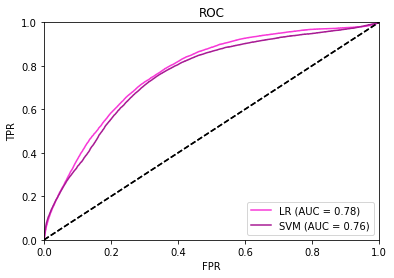

In [4]:
#ROC is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
#The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np

def plotAUC(pred,truth,label_string):
    
    #1.Calling the roc_curve function to get the X(fpr) and Y(tpr) values, fpr=false positive rate or fallout,tpr=true positive rate or recall,sensitivity
    fpr, tpr, thresholds = roc_curve(truth, pred)
    #2.Inputting fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    #choosing a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= label_string+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(predict_LR,data_test['Y'],  'LR')

plotAUC(predict_SVC,data_test['Y'], 'SVM')
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

<h2>Which of the two models is generally better at ranking the test set?</h2>
<br></br>
<font color='blue'><p>ROC curves are a common tool for visualizing model performance for classification and scoring.Here we are comparing the Logistic Regression model with the support vector machine's model. We see that the AUC score for LR(0.78) is 0.02 more than the AUC of SVM(0.76). Hence the LR model performs better at ranking the test set. However, looking at the curves I do not think there is any threshold value at which the LR would underperform the SVM as the two curves almost fit and overlap with each other</p></font>

### Part 3: Model selection with cross-validation (7 Points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.cross_validation.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: Use Sklearn's KFold method, but do not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm yourself!

<b>Grading guideline: if this function is done in more than 30 lines (not including empty lines), we will deduct 2 points.</b>

In [5]:
#Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it. 
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

def CrossValidation(dataset, label_name, k, cs):
    AUC_dic={}
    
    #We split our data into k subsets, and train on k-1 one of those subset. 
    #Use Kfold to create 4 folds
    #Cross validation begins here. We use Kfold function.
    kfolds = KFold(dataset.shape[0], n_folds = 4)
    for train_index,test_index in kfolds:
        #Spliting the dataset into cv_train & cv_validate according to previously defined fold mappings
        cv_train, cv_validate = dataset.iloc[train_index], dataset.iloc[test_index]
        for c in cs:
            clf = svm.SVC(C=c,kernel='linear')
            clf.fit(cv_train.drop(label_name,1),  cv_train[label_name]) 
            y_predict =clf.decision_function(cv_validate.drop(label_name,1))
            #Calculating the score
            AUC_c_k= roc_auc_score(cv_validate[label_name], y_predict)
            if (c in AUC_dic):
                AUC_dic[c].append(AUC_c_k)
            else:
                AUC_dic[c] = [AUC_c_k]

            
    return AUC_dic

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

answer here (verbal, no code):

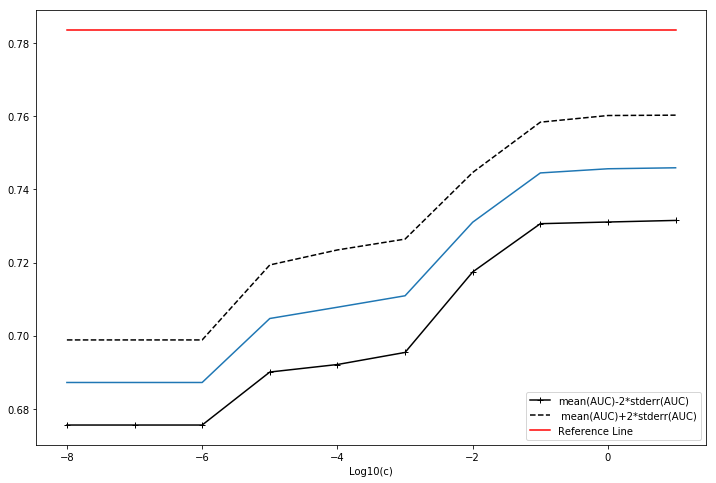

In [8]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math
dict_values={"log10C":[],"mean":[],"k+":[],"k--":[],"max_1std":[]}

C=[10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10**(1)]

aucs=CrossValidation(data_train,'Y', 10, C)
stdErr=[]
for key, value in aucs.items():
    mean_AUC=mean(value)
    StdErr_AUC= np.sqrt(np.var(value)/10)
    stdErr.append(StdErr_AUC)
    max_1std=mean_AUC-StdErr_AUC
    dict_values["log10C"].append(math.log10(key))
    dict_values["mean"].append(mean_AUC)
    dict_values["k+"].append(mean_AUC-(2*StdErr_AUC))
    dict_values["k--"].append(mean_AUC+(2*StdErr_AUC))
    dict_values["max_1std"].append(StdErr_AUC)
    
mean = np.array(dict_values["mean"])
log10C= np.array(dict_values["log10C"])
kPositive= np.array(dict_values["k+"])
Knegative=np.array(dict_values["k--"])

max_value=100*max(np.array(dict_values["max_1std"]))
max_array=[max_value for i in range(len(dict_values["max_1std"]))]
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.plot(log10C , mean)
plt.plot(log10C , kPositive , 'k+-', label = 'mean(AUC)-2*stderr(AUC)')
plt.plot(log10C , Knegative , 'k--', label = ' mean(AUC)+2*stderr(AUC)')
plt.plot(log10C , max_array , 'r'  , label = 'Reference Line')


plt.legend(loc = 4)
ax = fig.add_subplot(111)
ax.set_xlabel('Log10(c)')
try:
    best_c_ser = np.array(C)[(mean>max_value)].min()
    best_c_max = np.array(C)[(mean==max(mean))]
except ValueError:  
    pass


In [48]:
#Calculating the best regularization parameter C
#This is done as there was an exception thrown by python when trying to directly use 10**(best_c_Ser)
#I printed the value of best_c_ser and used it to calcuate the best classifier used in the functions below
print("best_c_ser is:",best_c_ser)
value=10**(-1)

best_c_ser is: -1


<h2>Conclusion</h2>
<font color='red'><p> We can see that the k-fold averages start to plateau and flatten around the place where Log10(C)=0. The out-of-the-box implementation of SVM in Sklearn uses log10(C)=1. It thus turns out that the default choice happens to be a good one.</p></font>


### Part 4: Learning Curve with Bootstrapping (8 Points)

In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

An example of using bootstrapping to build a learning curve can be found here: https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/python35/Lecture_ERM_LogReg_3.ipynb


1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). 
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so just use np.sqrt(np.var(...))


In [49]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    #auc_res = {"mean":[],"stdError":[]}
    scores=[]
    auc_res=[]
    for i in range(nruns):
        #Sampling the (sampsize) instances from train, with replacement
        train_samp = train.iloc[np.random.randint(0, len(train), size=sampsize)]
        #fitting either SVM or LR
        if(lr==1):
            logreg = linear_model.LogisticRegression(C=1e30)
            logreg.fit(train_samp.drop('Y', 1),train_samp['Y'])
            predict = logreg.predict_proba(test.drop('Y',1))[:,1]     
        else:
            #Making a classifier with the best regularization parameter as calculated before
            SVM = svm.SVC(kernel='linear', C = 0.1)
            SVM.fit(train_samp.drop('Y',1), train_samp['Y'])
            predict = SVM.decision_function(test.drop('Y',1))
        
        auc_res.append(roc_auc_score(test['Y'], predict))
    
   
    return [np.mean(auc_res), np.sqrt(np.var(auc_res))]
        


2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs). For SVM, use the value of C identified using the 1 standard error method from part 3. For LR, use the default C.

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [50]:
ns = [50, 100, 200, 500, 1000, 2000]

mean_lr = [] 
StError_lr = []
mean_SVM = [] 
StError_SVM = []
for n in ns:
    mean1, sterr1 = modBootstrapper(data_train, data_test, 20, n, 1, value)
    mean_lr.append(mean1)
    StError_lr.append(sterr1)
    mean2, sterr2= modBootstrapper(data_train,data_test, 20, n, 0, value)
    mean_SVM.append(mean2)
    StError_SVM.append(sterr2)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


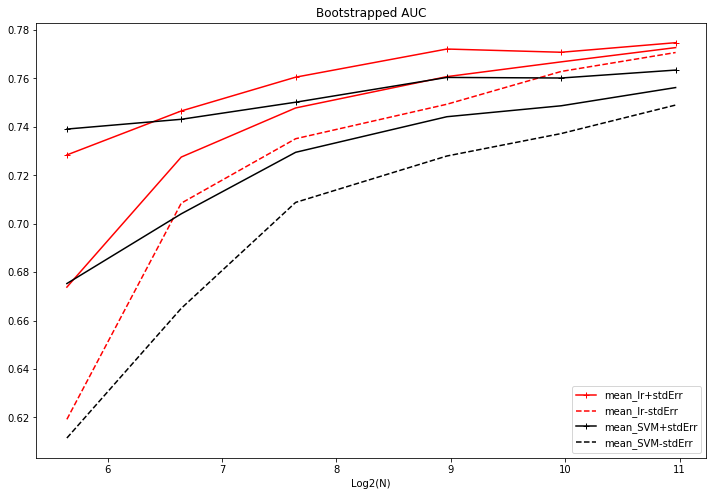

In [51]:
#Plot LR bootstrap
fig = plt.figure(figsize = (12, 8))
plt.plot(np.log2(ns),mean_lr, 'r')
plt.plot(np.log2(ns),mean_lr + np.array(StError_lr), 'r+-',label="mean_lr+stdErr")
plt.plot(np.log2(ns),mean_lr - np.array(StError_lr), 'r--',label="mean_lr-stdErr")
#Plot the SVM bootstrap
plt.plot(np.log2(ns), mean_SVM, 'k')
plt.plot(np.log2(ns), mean_SVM + np.array(StError_SVM), 'k+-',label="mean_SVM+stdErr")
plt.plot(np.log2(ns), mean_SVM- np.array(StError_SVM), 'k--',label="mean_SVM-stdErr")
plt.title('Bootstrapped AUC')
ax = fig.add_subplot(111)
ax.set_xlabel('Log2(N)')
plt.legend(loc = 4)

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


<h1>Better Algorithm</h1>
<font color="blue"><p>The SVM graph does better for the absolute minimum sample size tested here, but we can see from the confidence intervals that this advantage is not statistically significant. But looking at the graph , we can see that the LR does better for most small sample sizes. So in general, I would choose LR over SVM given the current sample size (or maybe less). For both algorithms, we can see that performance reaches a plateau point and doubling the data will likely not add large value to prediction performance. While we do not know exactly how much incremental AUC is worth in dollar terms, it is unlikely we'll get a lot of performance improvements (conditioned on using linear models only) with twice the amount of data.</font>

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased? (Hint: refer to ESL figure 7.8)?



<h2>Cross-Validation</h2>
<font color='green'><p>
One issue with cross-validation is that since the training set is not as big as the original training set, the estimates of prediction error will be biased up a little bit, because we have less data that we are working with. I feel that cross validation is negatively biased. The learning curves in figure 7.8 show that performance of a classifier generally decreases as the training data sample size decreases. The variance is reduced since there is more data, and so a slightly more complex model minimizes the expected error.</p>

<p>The exact trade-off depends on the data and the classifier. Cross-validation only uses (k-1)/k% of the data for training. If the learning curve hasn’t reached its plateau at (k-1)/k% of the data, then the cross-validation procedure will be negatively biased due to the smaller sample size. We can see in the learning curves that even at 90% of the data the performance is lower (though not statistically significant). Thus, we’d expect cross-validation in this case to be slightly negatively biased, which has the potential to result in sub-optimal decision making.</p></font>

<h2>References for this homework</h2>
<a href="https://stats.stackexchange.com/questions/61783/variance-and-bias-in-cross-validation-why-does-leave-one-out-cv-have-higher-var">Stats Exchange Website</a>
<a href="https://gerardnico.com/wiki/data_mining/cross_validation#cross-validation_error_estimate">Statistics Website</a>
<p>Class Lab works, Stackoverflow, http://www.ritchieng.com/machine-learning-evaluate-classification-model/</p>